In [1]:
!pip install shortuuid

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
import sys
import os
import math
import base64
import boto3
import sagemaker
import matplotlib.pyplot as plt
import numpy as np
import collections
from collections import defaultdict
from PIL import Image
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

To avoid altering the conda environment of this notebook and introducing versioning conflicts, we do not pip -r the bioims cli requirements.txt file, although this would would be preferable than using pip directly here. 

In [3]:
s3c = boto3.client('s3')

In [4]:
%pwd

'/root/bioimage-search/datasets/bbbc-021/notebooks'

Change this bucket to the 'data' bucket for your bioimage search project

In [5]:
bioimsArtifactBucket='bioimage-search-output'

In [6]:
# assumes cwd=/root/bioimage-search/datasets/bbbc-021/notebooks
sys.path.insert(0, "../../../cli/bioims/src")
import bioims as bi

In [7]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

## Prerequisites

### Permissions
This notebook requires adding the "BioimageSearch" managed policy to the SageMaker execution role. Do this by using the IAM console to add this managed policy to the role for this studio notebook. If the role for studio was auto-created it will begin with "AmazonSageMaker-ExecutionRole". The bioimage search managed policy arn will be something like: arn:aws:iam::580829821648:policy/BioimageSearchResourcePermissionsStack-biomageSearchManagedPolicy9CB9C1D7-SXEV4WNUCZ7V.

### TrainID
This notebook does a baseline, or sanity-check, on the training of the bbbc-021 dataset with a particular model, the context for which is specified by a BioimageSearch 'trainId', an output of the training process. If the evaluation of the results looks reasonable, then the comprehensive 'mechanism of action' (MOA) training series can be run, which creates a separate model for each chemical compound with known MOA. This collection of models, in turn, can be evaluated to determine the likelihood of whether a treatment (i.e., the application of a particular compound at a particular concentration) of unknown MOA would be properly classified. If so, then the model is likely to be useful for assigning MOA to treatments with unknown mechanisms of action, and more broadly for representing a molecule in 'MOA space'.

In [8]:
trainId = 'uhYHxfcpdbHWpjFSb2n6QT'

### Steps
* Get the Embedding for the TrainId
* Get the dimensions for the Embedding
* Get the list of compatible plates
* For each plate:
 * Get the origin row of each image to get its metadata
 * Get the embeddings for the specified TrainId
* Combine the metadata and embeddings into a tablular object
* Visualize separability
 * Compute the average embedding for each well
 * Label each well by known MOA (for cases where MOA is known)
 * Use a projection method (e.g., t-sne) to view the separability of results
* Create 'baseline' confusion matrix (not valid due to circular model inclusion, but just for sanity check)
 * For each treatment with known MOA:
   * Compute average across corresponding wells
   * Find the MOA of its nearest neighbor
 * Plot matrix

In [9]:
trainClient = bi.client('training-configuration')

In [10]:
trainInfo = trainClient.getTraining(trainId)

In [11]:
trainInfo

{'filterBucket': '',
 'sagemakerJobName': 'bioims-uhYHxfcpdbHWpjFSb2n6QT-8WJZcz5xpP7Lfeg3GTc75a',
 'messageId': 'd4c5d4c7-6465-4a45-9f05-719e8952069e',
 'filterKey': '',
 'trainId': 'uhYHxfcpdbHWpjFSb2n6QT',
 'embeddingName': 'bbbc021',
 'executeProcessPlate': 'false'}

In [12]:
embeddingInfo = trainClient.getEmbeddingInfo(trainInfo['embeddingName'])

In [13]:
embeddingInfo

{'roiDepth': 1,
 'trainingHyperparameters': {'backend': 'gloo',
  'batch_size': 1,
  'seed': 1,
  'epochs': 2},
 'roiHeight': 128,
 'trainId': 'origin',
 'inputHeight': 1024,
 'inputWidth': 1280,
 'comments': '',
 'inputChannels': 3,
 'imageMethodArn': 'arn:aws:batch:us-east-1:580829821648:job-definition/imagepreprocessingjobde-c7df1aec5a8b940:1',
 'embeddingVectorLength': 256,
 'trainingInstanceType': 'ml.g4dn.4xlarge',
 'plateMethodArn': 'arn:aws:batch:us-east-1:580829821648:job-definition/platepreprocessingjobde-f44b2d3675e9fc4:1',
 'inputDepth': 1,
 'modelTrainingScriptBucket': 'bioimage-search-input',
 'wellMethodArn': 'wellMethodArn-placeholder',
 'imagePostMethodArn': 'imagePostMethodArn-placeholder',
 'embeddingName': 'bbbc021',
 'modelTrainingScriptKey': 'bbbc021-1-train-script.py',
 'roiWidth': 128}

In [14]:
imageClient = bi.client('image-management')

In [15]:
plates = imageClient.listCompatiblePlates(embeddingInfo['inputWidth'], embeddingInfo['inputHeight'], embeddingInfo['inputDepth'], embeddingInfo['inputChannels'])

In [16]:
plates

[{'plateId': 'oqdwownrEbicuLbPPjU83g'},
 {'plateId': 'rYisgiA7hzqkZme3AQUhc5'},
 {'plateId': '8JUwBrxnW4t389H55toSDt'},
 {'plateId': 'smpuP3M32H7ovPi3FEQrX6'},
 {'plateId': 'wmBjU8R4fFCGDGFQUfnNca'},
 {'plateId': '6f9osva3H98mN2yZg9ufsM'},
 {'plateId': 'e5BmvvN5bkkxFi1zwWcUvY'},
 {'plateId': 'pHGmTcEeaJJAAfAFAJroib'},
 {'plateId': 'vzdeQK17iKCWVM51HAnPCE'},
 {'plateId': '2CxN3VeWU9ZBawWrGDjtZG'},
 {'plateId': '29gUbBN9sMpAfX82LeWSwv'},
 {'plateId': 'gP4mDmMNhmvoayzoRFu9RS'},
 {'plateId': 'gU8hZ6YTnDoGe4pqQ4S7VP'},
 {'plateId': 'tK9mT8u6CYCjEDryC1iRB1'},
 {'plateId': 'xgczHqUKaLMQGBPVfzRmNb'},
 {'plateId': 'rWdnnKwAHR1yW8x5mwM9SD'},
 {'plateId': 'pt1Vzk6NMzD5GvAzhC92x4'},
 {'plateId': 'w6EEKGpqNwGfKLWqfXHiLa'},
 {'plateId': 'rwYTFXPK1YAhSHz2U2WQci'},
 {'plateId': 'n4skn6kQmDhLa9YMdf4oCq'},
 {'plateId': 'nB2mbCnbYbLp3yvXFZQ5t8'},
 {'plateId': 'croKFXYMta6HidoEGwZ1JM'},
 {'plateId': 'xi1qJrABtoYiAcKryWEKAt'},
 {'plateId': 'pUXQVQJMQ2KazKSuD4p5aD'},
 {'plateId': 'bpytTMKpgTiFDHP6xUKpTW'},


In [17]:
imagePlateExample = imageClient.getImagesByPlateId(plates[0]['plateId'])

In [18]:
imagePlateExample[0]

{'Item': {'trainCategory': 'moa',
  'imageId': '1UFbH8WCXBvGV3EYvHiDqv',
  'plateId': 'oqdwownrEbicuLbPPjU83g',
  'trainId': 'origin',
  'depth': '1',
  'plateSourceId': 'Week2_24361',
  'bucket': 'bioimagesearchbbbc021stack-bbbc021bucket544c3e64-10ecnwo51127',
  'experiment': 'BBBC021_v1',
  'channelKeys': [{'name': 'dapi',
    'keysuffix': 'Week2_24361/Week2_180607_B10_s2_w159864310-FCF8-4ABE-A3F8-558A1309E401.tif'},
   {'name': 'tubulin',
    'keysuffix': 'Week2_24361/Week2_180607_B10_s2_w2AB02D693-2621-4E92-A220-55EFD359B05B.tif'},
   {'name': 'actin',
    'keysuffix': 'Week2_24361/Week2_180607_B10_s2_w45EEA7F71-6A14-40EC-8123-8481ACB0BE74.tif'}],
  'wellId': 'uL2D5852RSncfsyBq3R2fr',
  'imageSourceId': 'Week2_180607_B10_s2_w159864310-FCF8-4ABE-A3F8-558A1309E401',
  'messageId': '2572c105-1fd2-4c02-a76b-9f273c483edf',
  'searchReady': 'VALIDATED',
  'height': '1024',
  'width': '1280',
  'tagArr': [55],
  'trainSubclassType': 'compound',
  'wellSourceId': 'B10',
  'channels': '3',


In [19]:
embeddingPlateExample = imageClient.getImagesByPlateIdAndTrainId(plates[0]['plateId'], trainId)

In [20]:
embeddingPlateExample[2]

{'Item': {'imageId': '7uGAqqgHe3AUGWRUdV5Nbv',
  'embedding': "b'iFoVu9vzTL3/5n69lPSjPYakITxrLn+65NjjPUnoJTwnPr49QG2VPaiWZb3LhF88BMuWvYtA1TywLPY7J10WvYoAlDsNyyq7f0pAvQC2Nr0933a8PZYbvGc6WDvzlZg7DL/MvXC6vrygp9g9az+ZPLDTJj3LqUI9DEnkO8X7CL2X/Ts9/P9pvfq5jD20gMG9QwtOPRCNIb2oHo68FX9Ivcv9Fr0LGFy8YdWjPTVPuzuRTZ48J9lcvWVFj7xn8FK9PWqMPcJRnbtM/ww8zQV0PGVLRz2DRF+8v3qgPOtS3DxrRnK6ewE/vVl1gjySK4w9x5mUvKT3TD0HAwC9uIhMPRxyi7xg42c8G2SQPRCj8zybxem5aW27vJM4Wr1cNMo7yM63vbmDsD29Dou9f9qqvbCDk7ygV4u8DbCsvGDFYL1Vgw29PIuRPTOuxb2cQZk9LUnLvLtnmbxMSr67zO7RvXhcVD2Lh168gXydPMSNyjtp2ZS9y76MvadQOj3j7vC8SYAPvPmYx71FAy492pEJPfWOej31Bqs8gEbuPAcSsTyjiLU9G4Lcuo209zsgHB89TR2+PXBo+rsINNE8ZVzUPGOSeLxXB+m8uqSCPWndvzt0uQS9ZFYgPE2zJL3I+kw9A2KWPLR5zLwsahc9dsSRvU+Bfb3kdAW9d2NNvcsvKbyAV1c9E8tUvZUqHD2WgYa7G4uIvW87qr24O60945SDvXgtOr0ZDVs93dOuvJC03by8v9A9AT01PNQnnj3pqRK91CPovD3arzxAmkE8zfIUvbXSnD1Ao4E9SzSePK2AYb3V+pE8FMglvDvV97xcWg49tGcxPQuAQz1AOkU9zQJMO1NJpL13+sM9Gj0ivP2B6LuLtE28g/yUvS122D3jYCg8BWXjPLgDor11IF49mb6ZPKuFibrStak9mtCQO+D

In [21]:
#e1 = "b'i6qJPbpKHL5IZSK+akeqPRVh570Wlvm869mrvXp6Pj5qKMy918wAvnCsQr6zHe+91nTsvalCALx3twG+Et21PRMvhb1Qzkw8mda2PYVZtD2RXyu7ggIWPs4AnT2keSE9oQ8ePqkEvL0bN4K97uzDPQ1NuD22JbO8TTCPvHkVCr0='"
e1 = embeddingPlateExample[2]['Item']['embedding']

In [22]:
e2 = e1.split("\'")

In [23]:
e3=e2[1].encode()

In [24]:
e4 = base64.decodebytes(e3)
e5 = np.frombuffer(e4, dtype=np.float32)

In [25]:
e5

array([-2.27895565e-03, -5.00372462e-02, -6.22320138e-02,  8.00563395e-02,
        9.86588560e-03, -9.73439484e-04,  1.11253530e-01,  1.01261819e-02,
        9.28919837e-02,  7.29622841e-02, -5.60518801e-02,  1.36425002e-02,
       -7.36294091e-02,  2.60317530e-02,  7.51265138e-03, -3.67099307e-02,
        4.51666582e-03, -2.60609691e-03, -4.69460450e-02, -4.46071625e-02,
       -1.50678726e-02, -9.49626882e-03,  3.29937949e-03,  4.65654721e-03,
       -9.99737680e-02, -2.32822597e-02,  1.05788469e-01,  1.87069979e-02,
        4.07292247e-02,  4.75252084e-02,  6.96671568e-03, -3.34432311e-02,
        4.58961390e-02, -5.71288913e-02,  6.87140971e-02, -9.44837630e-02,
        5.03037088e-02, -3.94411683e-02, -1.73486024e-02, -4.89493199e-02,
       -3.68631296e-02, -1.34334667e-02,  7.99968317e-02,  5.71622932e-03,
        1.93240959e-02, -5.39180301e-02, -1.74891446e-02, -5.14987968e-02,
        6.85620084e-02, -4.80100606e-03,  8.60578939e-03,  1.48939611e-02,
        4.86558862e-02, -

In [26]:
embeddingWidth=len(e5)

In [27]:
embeddingWidth

256

In [28]:
plateMap={}

In [29]:
for plateEntry in plates:
    plateId=plateEntry['plateId']
    print("Adding plateId {}".format(plateId))
    images=imageClient.getImagesByPlateId(plateId)
    embeddings=imageClient.getImagesByPlateIdAndTrainId(plateId, trainId)
    imageMap={}
    for imageItem in images:
        image=imageItem['Item']
        imageId=image['imageId']
        imageMap[imageId]=image
    print("  found {} image entries".format(len(imageMap)))
    embeddingMap={}
    for embeddingItem in embeddings:
        if 'Item' in embeddingItem:
            embedding=embeddingItem['Item']
            imageId=embedding['imageId']
            e1=embedding['embedding']
            e2=e1.split("\'")
            e3=e2[1].encode()
            e4=base64.decodebytes(e3)
            e5=np.frombuffer(e4, dtype=np.float32)
            embedding['np']=e5
            embeddingMap[imageId]=embedding
    print("  found {} embedding entries".format(len(embeddingMap)))
    plateInfo = {
        "images" : imageMap,
        "embeddings" : embeddingMap
    }
    plateMap[plateId]=plateInfo

Adding plateId oqdwownrEbicuLbPPjU83g
  found 240 image entries
  found 204 embedding entries
Adding plateId rYisgiA7hzqkZme3AQUhc5
  found 240 image entries
  found 239 embedding entries
Adding plateId 8JUwBrxnW4t389H55toSDt
  found 240 image entries
  found 234 embedding entries
Adding plateId smpuP3M32H7ovPi3FEQrX6
  found 240 image entries
  found 224 embedding entries
Adding plateId wmBjU8R4fFCGDGFQUfnNca
  found 240 image entries
  found 240 embedding entries
Adding plateId 6f9osva3H98mN2yZg9ufsM
  found 240 image entries
  found 230 embedding entries
Adding plateId e5BmvvN5bkkxFi1zwWcUvY
  found 240 image entries
  found 240 embedding entries
Adding plateId pHGmTcEeaJJAAfAFAJroib
  found 240 image entries
  found 236 embedding entries
Adding plateId vzdeQK17iKCWVM51HAnPCE
  found 240 image entries
  found 240 embedding entries
Adding plateId 2CxN3VeWU9ZBawWrGDjtZG
  found 240 image entries
  found 232 embedding entries
Adding plateId 29gUbBN9sMpAfX82LeWSwv
  found 240 image entr

# Review Plate Images

Here I'd like to select a plate and visualize all composite images.

In [30]:
artifactClient=bi.client('artifact')

In [31]:
imageId0 = embeddingPlateExample[2]['Item']['imageId']

In [32]:
artifactClient.getArtifacts(imageId0, 'origin')

[{'contextId': '7uGAqqgHe3AUGWRUdV5Nbv#origin',
  'annotation': [],
  'description': '',
  'artifact': 's3key#artifact/plate/oqdwownrEbicuLbPPjU83g/default/image/7uGAqqgHe3AUGWRUdV5Nbv/medium-2d.png',
  'createTimestamp': '1629307690520'},
 {'contextId': '7uGAqqgHe3AUGWRUdV5Nbv#origin',
  'annotation': [],
  'description': '',
  'artifact': 's3key#artifact/plate/oqdwownrEbicuLbPPjU83g/default/image/7uGAqqgHe3AUGWRUdV5Nbv/thumbnail-2d.png',
  'createTimestamp': '1629307689246'}]

In [33]:
plateId = imagePlateExample[0]['Item']['plateId']

In [34]:
def showImage(im):
    #plt.figure(figsize=(20,15))
    plt.figure(figsize=(4,15))
    plt.subplot(1,1,1)
    plt.xticks([])
    plt.yticks([])
    print("shape=", im.size)
    print("format=", im.format)
    ip=plt.imshow(im)
    #plt.xlabel(0)
    plt.show()

In [35]:
def displayImages(images, columns, fx, fy):
    plt.figure(figsize=(fx,fy))
    l =len(images)
    spx=columns
    spy=math.ceil(l/spx)
    i=0
    for imkey in images:
        fo = s3c.get_object(Bucket=bioimsArtifactBucket, Key=imkey)
        fs = fo['Body']
        im = Image.open(fs)
        plt.subplot(spy,spx,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(im)
        plt.xlabel(i)
        i+=1

In [36]:
def displayThumbnailsForPlate(plateId):
    plateDataMap = plateMap[plateId]
    imageMap = plateDataMap['images']
    imageIds = imageMap.keys()
    keyList = []
    for imageId in imageIds:
        artifactList = artifactClient.getArtifacts(imageId, 'origin')
        for artifact in artifactList:
            s3key = artifact['artifact']
        if s3key.endswith('thumbnail-2d.png'):
            components = s3key.split('#')
            keyList.append(components[1])
    displayImages(keyList, 10, 20, 40)

This step could take 1-2 minutes to render

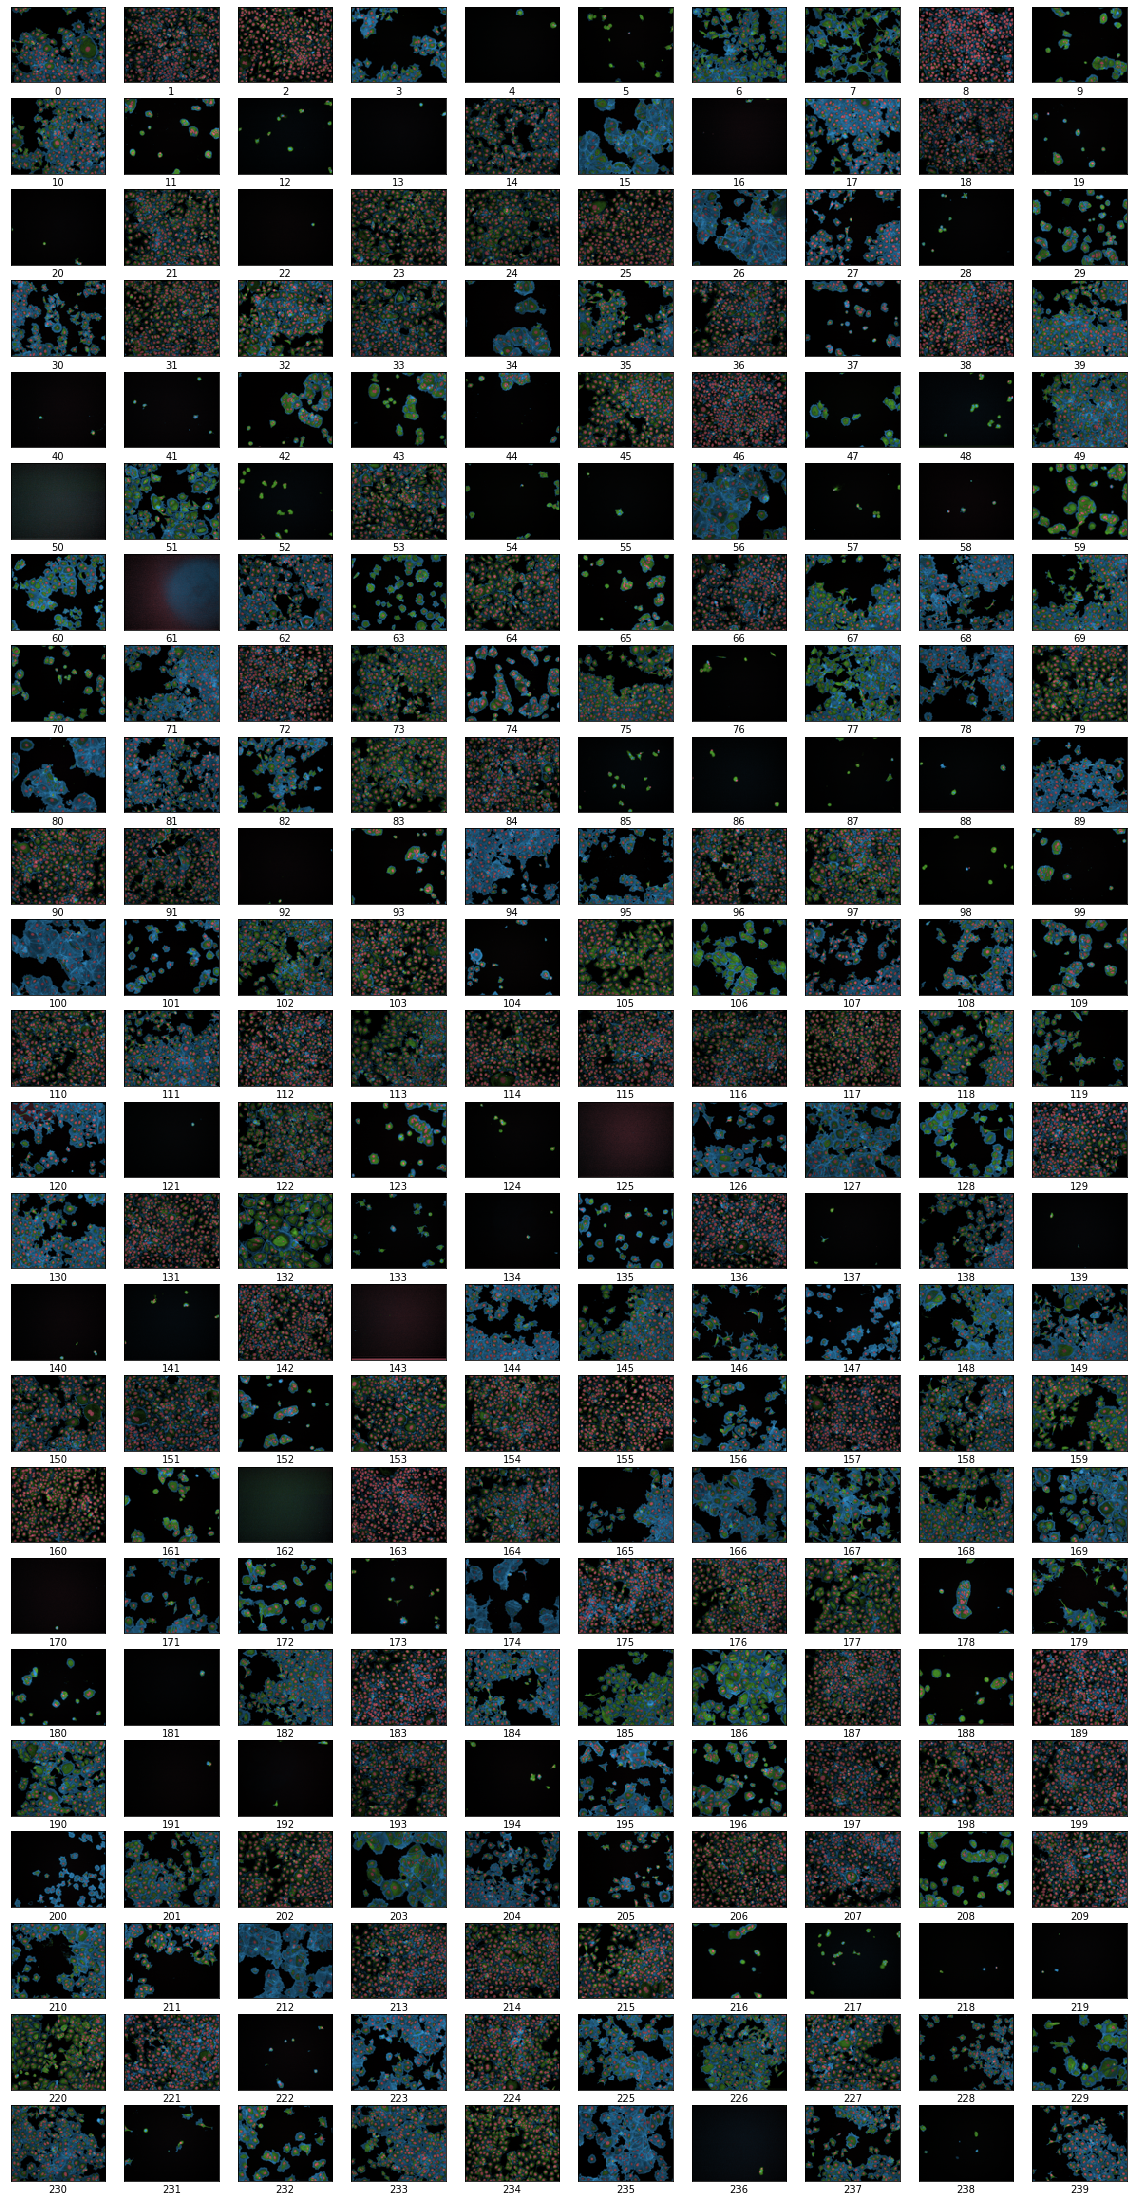

In [37]:
displayThumbnailsForPlate(plateId)

Next, we create a mapping from MOA->well-embedding, where we will naively take the average of the embeddings for each well (there are several images per well). An alternative would be taking the median.

In [38]:
wellMap = {}

In [39]:
imageCount=0
for plateId in plateMap:
    print("plate {}".format(plateId))
    plateInfo = plateMap[plateId]
    imageMap = plateInfo['images']
    embeddingMap = plateInfo['embeddings']
    for imageId in imageMap:
        imageInfo = imageMap[imageId]
        if imageId in embeddingMap:
            embeddingInfo = embeddingMap[imageId]
            if 'trainLabel' in imageInfo and 'np' in embeddingInfo:
                wellId = imageInfo['wellId']
                if wellId not in wellMap:
                    imageArr = []
                    wellMap[wellId]=imageArr
                imageArr = wellMap[wellId]
                imageEntry = {}
                imageEntry['label']=imageInfo['trainLabel']
                imageEntry['np']=embeddingInfo['np']
                imageArr.append(imageEntry)
                imageCount+=1
print("Found {} wells".format(len(wellMap)))
print("Found {} images with MOA labels and embeddings".format(imageCount))

plate oqdwownrEbicuLbPPjU83g
plate rYisgiA7hzqkZme3AQUhc5
plate 8JUwBrxnW4t389H55toSDt
plate smpuP3M32H7ovPi3FEQrX6
plate wmBjU8R4fFCGDGFQUfnNca
plate 6f9osva3H98mN2yZg9ufsM
plate e5BmvvN5bkkxFi1zwWcUvY
plate pHGmTcEeaJJAAfAFAJroib
plate vzdeQK17iKCWVM51HAnPCE
plate 2CxN3VeWU9ZBawWrGDjtZG
plate 29gUbBN9sMpAfX82LeWSwv
plate gP4mDmMNhmvoayzoRFu9RS
plate gU8hZ6YTnDoGe4pqQ4S7VP
plate tK9mT8u6CYCjEDryC1iRB1
plate xgczHqUKaLMQGBPVfzRmNb
plate rWdnnKwAHR1yW8x5mwM9SD
plate pt1Vzk6NMzD5GvAzhC92x4
plate w6EEKGpqNwGfKLWqfXHiLa
plate rwYTFXPK1YAhSHz2U2WQci
plate n4skn6kQmDhLa9YMdf4oCq
plate nB2mbCnbYbLp3yvXFZQ5t8
plate croKFXYMta6HidoEGwZ1JM
plate xi1qJrABtoYiAcKryWEKAt
plate pUXQVQJMQ2KazKSuD4p5aD
plate bpytTMKpgTiFDHP6xUKpTW
plate uBUSj9FZpod4MeXSC1Q4FA
plate ffGkXXLtragRfJx5r3p6d1
plate 1dUVX8amicQ86FZjExpsb3
plate atkTZd9VqgWdBxBuC7ipL6
plate aBH5c9NmeDU5e1ZhNtvUHN
plate oTpwVP6jDMXb2RaLjrjGx9
plate 8xpKyDm72zWwBLnpWUA8WB
plate 4kTFLP7oTBX1w8PDG2kSpA
plate jrjbogvdh6PZHEmAQbx4uG
plate iLANhU5Y

In [40]:
moaMap={}

In [41]:
for wellId in wellMap:
    imageArr = wellMap[wellId]
    label = imageArr[0]['label']
    if label not in moaMap:
        wellArr = []
        moaMap[label]=wellArr
    wellArr = moaMap[label]
    embeddingArr = []
    for imageEntry in imageArr:
        npe = imageEntry['np']
        embeddingArr.append(npe)
    npa = np.asarray(embeddingArr)
    npm = np.mean(npa, axis=0)
    wellArr.append(npm)

In [42]:
embeddingCount=0
for label in moaMap:
    wellArr = moaMap[label]
    print("label {} has {} entries".format(label, len(wellArr)))
    embeddingCount += len(wellArr)

label Protein degradation has 94 entries
label Microtubule stabilizers has 402 entries
label DMSO has 330 entries
label Cholesterol-lowering has 48 entries
label DNA replication has 96 entries
label Aurora kinase inhibitors has 72 entries
label DNA damage has 96 entries
label Eg5 inhibitors has 45 entries
label Microtubule destabilizers has 96 entries
label Actin disruptors has 72 entries
label Epithelial has 64 entries
label Protein synthesis has 72 entries
label Kinase inhibitors has 48 entries


The embedding count below should match the number of wells

In [43]:
embeddingCount

1535

In [44]:
moaSortedArr = []
moaLabelMap = {}
for label in moaMap:
    moaSortedArr.append(label)

In [45]:
moaSortedArr

['Protein degradation',
 'Microtubule stabilizers',
 'DMSO',
 'Cholesterol-lowering',
 'DNA replication',
 'Aurora kinase inhibitors',
 'DNA damage',
 'Eg5 inhibitors',
 'Microtubule destabilizers',
 'Actin disruptors',
 'Epithelial',
 'Protein synthesis',
 'Kinase inhibitors']

In [46]:
moaSortedArr.sort()

In [47]:
moaSortedArr

['Actin disruptors',
 'Aurora kinase inhibitors',
 'Cholesterol-lowering',
 'DMSO',
 'DNA damage',
 'DNA replication',
 'Eg5 inhibitors',
 'Epithelial',
 'Kinase inhibitors',
 'Microtubule destabilizers',
 'Microtubule stabilizers',
 'Protein degradation',
 'Protein synthesis']

In [48]:
for i, l in enumerate(moaSortedArr):
    moaLabelMap[l] = i

In [49]:
orderedEmbedding = np.empty( (embeddingCount, embeddingWidth), dtype=np.float32 )

In [50]:
orderedLabels = np.empty(embeddingCount, dtype=np.int32)

In [51]:
i=0
for label in moaMap:
    wellArr = moaMap[label]
    for embedding in wellArr:
        orderedEmbedding[i]=embedding
        orderedLabels[i]=moaLabelMap[label]
        i += 1

In [52]:
near_neighbors_per_example = 10
gram_matrix = np.einsum("ae,be->ab", orderedEmbedding, orderedEmbedding)
near_neighbors = np.argsort(gram_matrix.T)[:, -(near_neighbors_per_example + 1) :]

In [53]:
class_idx_to_train_idxs = defaultdict(list)
for y_train_idx, y in enumerate(orderedLabels):
    class_idx_to_train_idxs[y].append(y_train_idx)

In [54]:
num_classes = 13
confusion_matrix = np.zeros((num_classes, num_classes))

# For each class.
for class_idx in range(num_classes):
    example_idxs = class_idx_to_train_idxs[class_idx][:near_neighbors_per_example]
    for y_test_idx in example_idxs:
        # Count the classes of its near neighbours.
        for nn_idx in near_neighbors[y_test_idx][:-1]:
            nn_class_idx = orderedLabels[nn_idx]
            confusion_matrix[class_idx, nn_class_idx] += 1

NOTE: with Confusion Matrix below, category 'DMSO' (predicted label 3), is equivalent to 'no treatment' since DMSO is the chemical control buffer. Therefore, we should not be surprised to see off-diagonals that represent a kind of 'best guess' network outcome. 

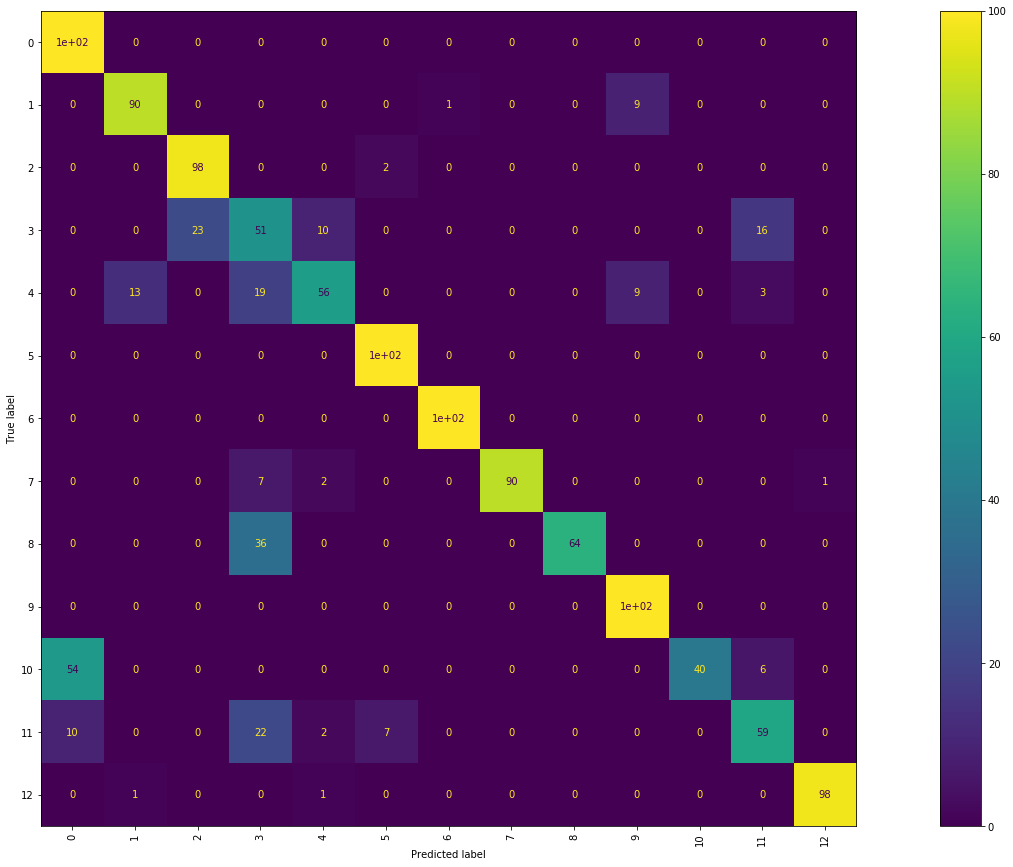

In [55]:
# Display a confusion matrix.
labels = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "10",
    "11",
    "12"
]
plt.rcParams["figure.figsize"] = (30,15)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
plt.show()

In [56]:
moaLabelMap

{'Actin disruptors': 0,
 'Aurora kinase inhibitors': 1,
 'Cholesterol-lowering': 2,
 'DMSO': 3,
 'DNA damage': 4,
 'DNA replication': 5,
 'Eg5 inhibitors': 6,
 'Epithelial': 7,
 'Kinase inhibitors': 8,
 'Microtubule destabilizers': 9,
 'Microtubule stabilizers': 10,
 'Protein degradation': 11,
 'Protein synthesis': 12}

In [57]:
colorList=['b', '#55ff55', 'r', 'c', 'm', 'y', 'k', '#eeeeee', '#777777', '#ff9999', '#880000', '#009900', '#000088']

NOTE: we remove DMSO from the t-sne plot since it is the 'no treatment' control

In [58]:
embeddingClassMembership=[]
for c in range(num_classes):
    if c == 3:
        r1 = orderedLabels == -1
    else:
        r1 = orderedLabels == c
    r2 = collections.Counter(r1)
    embeddingClassMembership.append(r1)

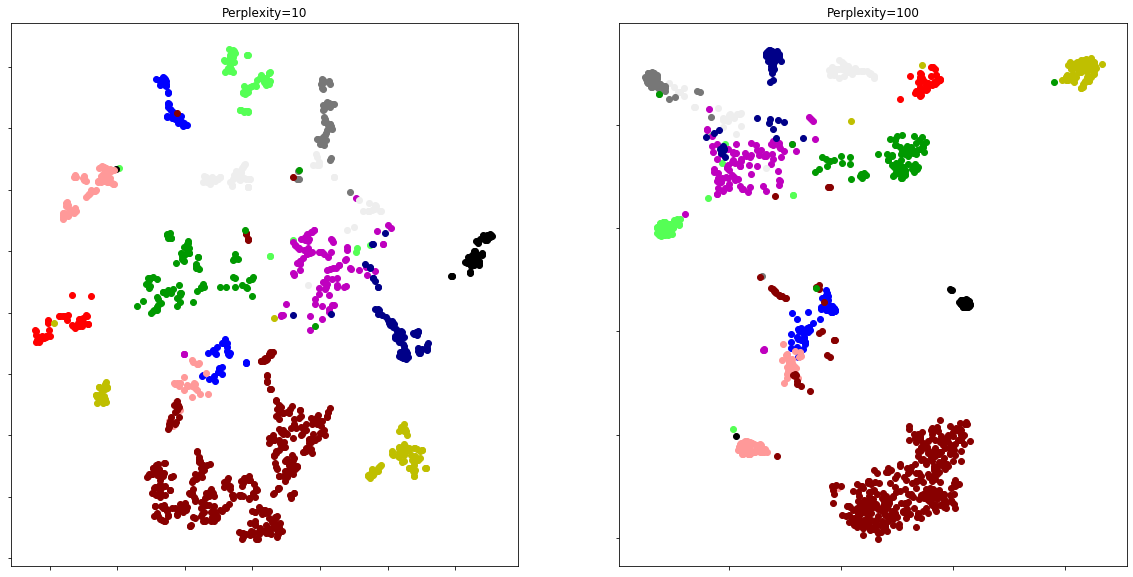

In [59]:
(fig2, subplots2) = plt.subplots(1, 2, figsize=(20, 10))
perplexities = [10, 100]

for i, perplexity in enumerate(perplexities):
    ax = subplots2[i]
    tsne = manifold.TSNE(n_components=2, init='random', random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(orderedEmbedding)
    ax.set_title("Perplexity=%d" % perplexity)
    for cl in range(num_classes):
        if cl != 3:
            ax.scatter(Y[embeddingClassMembership[cl], 0], Y[embeddingClassMembership[cl], 1], c=colorList[cl])
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')